In [1]:
import pandas as pd
import logging
import logging.config
import yaml
import matplotlib.pyplot as plt
import storage
import extraction

%matplotlib inline

In [2]:
def setupLogging():
    with open('../config/logConfig.yml', 'rt') as file:
        config = yaml.safe_load(file.read())
        logging.config.dictConfig(config)

setupLogging()
logger = logging.getLogger()
logger.debug("mon string de test")
logger.warning("mon string de test")


'''handler = logging.handlers.WatchedFileHandler(os.environ.get("LOGFILE", "../log/loader.log"))
formatter = logging.Formatter(logging.BASIC_FORMAT)
handler.setFormatter(formatter)
root = logging.getLogger()
root.setLevel(os.environ.get("LOGLEVEL", "DEBUG"))
root.addHandler(handler)
 
try:
    exit(main())
except Exception:
    logging.exception("Exception in main()")
    exit(1)'''

2020-03-29 00:50:14,850 - root - DEBUG - mon string de test
2020-03-29 00:50:14,853 - root - WARNING - mon string de test


'handler = logging.handlers.WatchedFileHandler(os.environ.get("LOGFILE", "../log/loader.log"))\nformatter = logging.Formatter(logging.BASIC_FORMAT)\nhandler.setFormatter(formatter)\nroot = logging.getLogger()\nroot.setLevel(os.environ.get("LOGLEVEL", "DEBUG"))\nroot.addHandler(handler)\n \ntry:\n    exit(main())\nexcept Exception:\n    logging.exception("Exception in main()")\n    exit(1)'

In [3]:
# Read TSV files
# Keeping it small for now
#train_df = pd.read_table('../data/Train_GCC-training.tsv', header = None, names = ['caption', 'url', 'statuscode'] )
validate_df = pd.read_table('../data/Validation_GCC 1.1.0-Validation.tsv', header = None, names = ['caption', 'url', 'statuscode']) 
validate_df.statuscode = 0
validate_df.head(20)

,caption,url,statuscode
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,0
1,an angler fishes river on a snowy day .,http://www.standard.net/image/2015/02/04/800x_...,0
2,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...,0
3,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...,0
4,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...,0
5,the - bedroom stone cottage can sleep people,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,0
6,film of a garbage truck,http://www.waste360.com/sites/waste360.com/fil...,0
7,young woman seated on the beach,https://media.gettyimages.com/photos/young-wom...,0
8,party in the park under cherry blossoms,https://worldjourneysdiscover.files.wordpress....,0
9,classical music 's rising stars join conducted...,http://piquemagazine.uk/wp-content/uploads/201...,0


In [4]:
size = 300 , 300 
extraction.request_data_and_store(validate_df.head(20), size, "validation")  
 

2020-03-29 00:50:15,490 - root - INFO - validation-- URL#0 Http code: 200
2020-03-29 00:50:15,493 - root - DEBUG - https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg
author : a life in photography -- in pictures
2020-03-29 00:50:15,755 - root - INFO - validation-- URL#1 Http code: 404
2020-03-29 00:50:16,301 - root - INFO - validation-- URL#2 Http code: 200
2020-03-29 00:50:16,305 - root - DEBUG - http://indianapolis-photos.funcityfinder.com/files/2009/12/Clearwater-Crossing-Shopping-Center-sign-Indianapolis-Indiana.jpg
photograph of the sign being repaired by brave person
2020-03-29 00:50:16,556 - root - INFO - validation-- URL#3 Http code: 200
2020-03-29 00:50:16,560 - root - DEBUG - http://www.abc.net.au/news/image/9066492-3x2-700x467.jpg
the player staring intently at a computer screen .
2020-03-29 00:50:17,405 - root - INFO - validation-- URL#4 Http code: 200
2020-03-29 00:50:17,409 - root - DEBUG - https://www.featurepics.com/StockImage

In [5]:
def retrieve(set_name): 
    # For the sake of the exercise, retrieves some hdf5 stored images and captions - Will be used later on when creating the Train/Test dataset
    for idx in range(10):
        try:
            status, image, caption = storage.read_image(set_name, idx)
            print(status)
            if (int(status) == 200):

                print(image.shape)
                print(caption)
                plt.imshow(image)
                plt.show()
           
        except KeyError:
            # Ignores files not found - probably an HHTP error when requesting the URL
            # Later - Keep count of the minning files to know the exact size of the dataset
            print("Missing index - image not found - probably an HHTP error when requesting the URL " + str(idx))
            continue

    return

<class 'numpy.ndarray'>
200
(300, 300, 3)
author : a life in photography -- in pictures


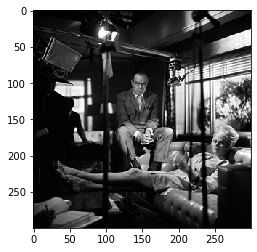

<class 'numpy.ndarray'>
404
<class 'numpy.ndarray'>
200
(300, 300, 3)
photograph of the sign being repaired by brave person


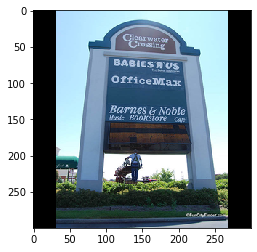

<class 'numpy.ndarray'>
200
(300, 300, 3)
the player staring intently at a computer screen .


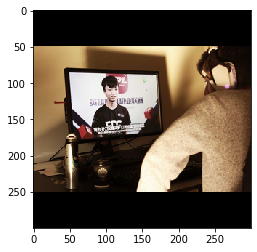

<class 'numpy.ndarray'>
200
(300, 300, 3)
globes : the green 3d person carrying in hands globe


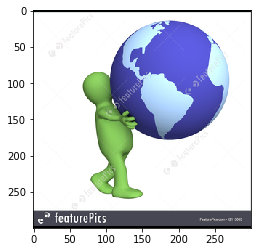

<class 'numpy.ndarray'>
200
(300, 300, 3)
the - bedroom stone cottage can sleep people


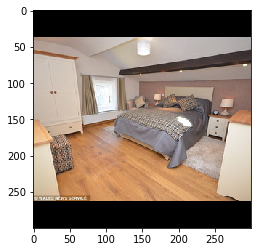

<class 'numpy.ndarray'>
200
(300, 300, 3)
film of a garbage truck


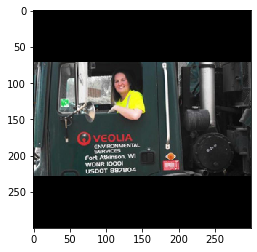

<class 'numpy.ndarray'>
200
(300, 300, 3)
young woman seated on the beach


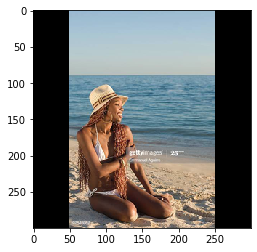

<class 'numpy.ndarray'>
200
(300, 300, 3)
party in the park under cherry blossoms


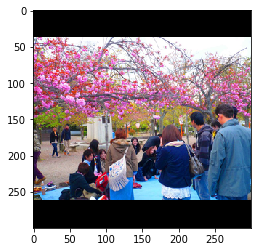

<class 'numpy.ndarray'>
404


In [6]:
retrieve("validation")

In [7]:
validate_df.columns

Index(['caption', 'url', 'statuscode'], dtype='object')

In [8]:
validate_df.head(20)

,caption,url,statuscode
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,200
1,an angler fishes river on a snowy day .,http://www.standard.net/image/2015/02/04/800x_...,404
2,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...,200
3,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...,200
4,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...,200
5,the - bedroom stone cottage can sleep people,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,200
6,film of a garbage truck,http://www.waste360.com/sites/waste360.com/fil...,200
7,young woman seated on the beach,https://media.gettyimages.com/photos/young-wom...,200
8,party in the park under cherry blossoms,https://worldjourneysdiscover.files.wordpress....,200
9,classical music 's rising stars join conducted...,http://piquemagazine.uk/wp-content/uploads/201...,404
